In [14]:
import bokeh
from bokeh.charts import Scatter, output_file, show
from bokeh.io import output_notebook
from bokeh.plotting import figure,show
from bokeh.resources import CDN
from bokeh.embed import file_html
output_notebook()

import sys
sys.path.append('/Users/jaredlorince/Downloads/tsne_python/')
import numpy as np
import pandas as pd
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist,squareform,cosine,euclidean
from sklearn.metrics.pairwise import pairwise_distances
from urllib import unquote_plus
import scipy.io as sio

import seaborn
from matplotlib import pyplot as plt
%matplotlib inline
from seaborn import color_palette
colors = color_palette()

Loading BokehJS ...

In [1]:
# Generate all genre data for color mapping
if False:
    vocab_idx = {}
    for line in open('../GenreModeling/data/vocab_idx'):
        line = line.strip().split('\t')
        #vocab_idx[int(line[1])] = unquote_plus(line[0]).title()
        vocab_idx[int(line[1])] = line[0]
    gn_data = pd.read_table('/Users/jaredlorince/Dropbox/gracenote_song_data')
    artist_data = gn_data.groupby('gn_artist').apply(lambda df: df.iloc[0])
    genre_data = artist_data[['genre1','genre2','genre3']].reindex(pd.Series(vocab_idx.values())).reset_index()
    genre_data.to_csv("/Users/jaredlorince/git/MusicForaging/GenreModeling/data/gracenote_genre_data.csv",index=False)

In [2]:
# load saved genre data and the tSNE data (from Matlab) that we want to plot
genre_data = pd.read_csv("/Users/jaredlorince/git/MusicForaging/GenreModeling/data/gracenote_genre_data.csv")
#Y = sio.loadmat('/Users/jaredlorince/Downloads/tSNE_matlab/result_10000_nmf.mat')['result']

In [213]:
N=50000
test = np.loadtxt('/Users/jaredlorince/git/lib/bhtsne/output_normed',delimiter='\t')[:N]
#test = sio.loadmat('/Users/jaredlorince/Downloads/tSNE_matlab/result_20k.mat')['result'][:N]
vocab_idx = {}
for line in open('../GenreModeling/data/vocab_idx'):
    line = line.strip().split('\t')
    #vocab_idx[int(line[1])] = unquote_plus(line[0]).title()
    vocab_idx[int(line[1])] = line[0]

genre_level='1'
genres = genre_data['genre'+genre_level].unique()

def get_color(genre):
    if genre is np.nan or genre=='other':
        genre = 'other/unknown'
    color = color_dict[genre]
    return genre,color

color_dict = dict(zip(['rock', 'alternative & punk', 'pop', 'electronica', 'urban',
       'traditional', 'soundtrack', 'jazz', 'classical'],['#%02x%02x%02x' % (a, b, c) for a,b,c in np.round(255*np.array(color_palette("Set1",n_colors=9))).astype(int)]))
color_dict['other/unknown'] = '#000000'
colors = [get_color(g)[1] for g in genre_data['genre1'].values[:len(test)]]

raw_source = pd.DataFrame(dict(
    x=test[:,0],
    y=test[:,1],
    label=[unquote_plus(vocab_idx[i]) for i in range(len(test))],
    color=colors,
    genre = [get_color(g)[0] for g in genre_data['genre1'].values[:len(test)]]))

#raw_source.head()

In [214]:
if True:
    bokeh.plotting.curdoc().clear()
    saveit = False
    from bokeh.models import Circle,BoxSelectTool, BoxZoomTool, LassoSelectTool,Text,HoverTool
    from bokeh.plotting import ColumnDataSource
    from collections import OrderedDict

    TOOLS="box_zoom,pan,reset,box_select,wheel_zoom,help,hover"
    p = figure(plot_width=1000, plot_height=1000,tools=TOOLS)#,x_range=(-10,10))

    for genre in raw_source['genre'].unique():
        if genre == 'other/unknown':
            continue
        source = ColumnDataSource(raw_source[raw_source['genre']==genre])
        p.circle(x='x',y='y',size=5,source=source,color='color',selection_color='color',nonselection_color='color',alpha=0.5,legend=genre)
        p.text(x='x',y='y',text='label',source=source,alpha=0.,selection_text_alpha=.55,nonselection_text_alpha=0.)

    hover = p.select(dict(type=HoverTool))
    hover.tooltips = '@label'

    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.yaxis.visible = None
    p.xaxis.visible = None

    if saveit:
        html = file_html(p, CDN, "artist feature space visualization")
        with open('/Users/jaredlorince/Downloads/test.html','w') as f:
            f.write(html)
    show(p)


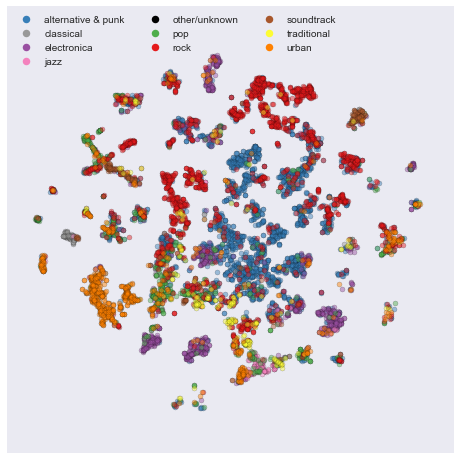

In [165]:
### static versions of tsne viz for paper

from matplotlib import pyplot as plt
%matplotlib inline


import scipy.io as sio

for f in ('result_10000',):#,'result_10000_nmf','result_10000_userlda_vanilla'):

    Y = sio.loadmat('/Users/jaredlorince/Downloads/tSNE_matlab/{}.mat'.format(f))['result']

    test = Y[:10000]
    genre_data = genre_data[:len(test)]


    def get_color(genre):
        if genre is np.nan or genre=='other':
            genre = 'other/unknown'
        color = color_dict[genre]
        return genre,color

    #color_dict = dict(zip(['rock', 'alternative & punk', 'pop', 'electronica', 'urban',
    #       'traditional', 'soundtrack', 'jazz', 'classical'],['#%02x%02x%02x' % (a, b, c) for a,b,c in np.array(color_palette("Set1",n_colors=9))]))
    color_dict = dict(zip(['rock', 'alternative & punk', 'pop', 'electronica', 'urban',
           'traditional', 'soundtrack', 'jazz', 'classical'],['#%02x%02x%02x' % (a, b, c) for a,b,c in np.round(255*np.array(color_palette("Set1",n_colors=9))).astype(int)]))
    color_dict['other/unknown'] = '#000000'
    #color_dict['other'] = (0.,0.,0.)
    #color_dict[np.nan] = (0.,0.,0.)
    colors = np.array([get_color(g)[1] for g in genre_data['genre1'].values[:len(test)]])


    fig,ax = plt.subplots(1,1,figsize=(8,8))
    for g in sorted(color_dict.keys()):
        if g == 'other/unkonwn':
            indices = genre_data[(genre_data['genre1'].isin([np.nan,'other','unknown']))]['genre1'].index.values
        else:
            indices = genre_data[genre_data['genre1']==g]['genre1'].index.values
        ax.scatter(test[indices,0],test[indices,1],c=color_dict[g],s=25,alpha=0.45)
        legend_line_1 = ax.plot(np.NaN, np.NaN, marker = '.', ls='',ms=15, label=g, c=color_dict[g])

    ax.grid()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    #ax.set_xlim(-145,145)
    #ax.set_ylim(-130,185)
    #ax.legend(bbox_to_anchor=(1.35,1))
    # handles, labels = ax.get_legend_handles_labels()
    # for h in handles:
    #     h.set_alpha(1.)
    #legend = ax.legend(handles,labels,loc='upper left',ncol=3)#,fancybox=True,framealpha=0.5,frameon=True)
    ax.legend(loc='upper left',ncol=3)
    #legend.get_frame().set_color('gray')



    #fig.savefig('/Users/jaredlorince/Desktop/test.pdf',bbox_inches='tight')

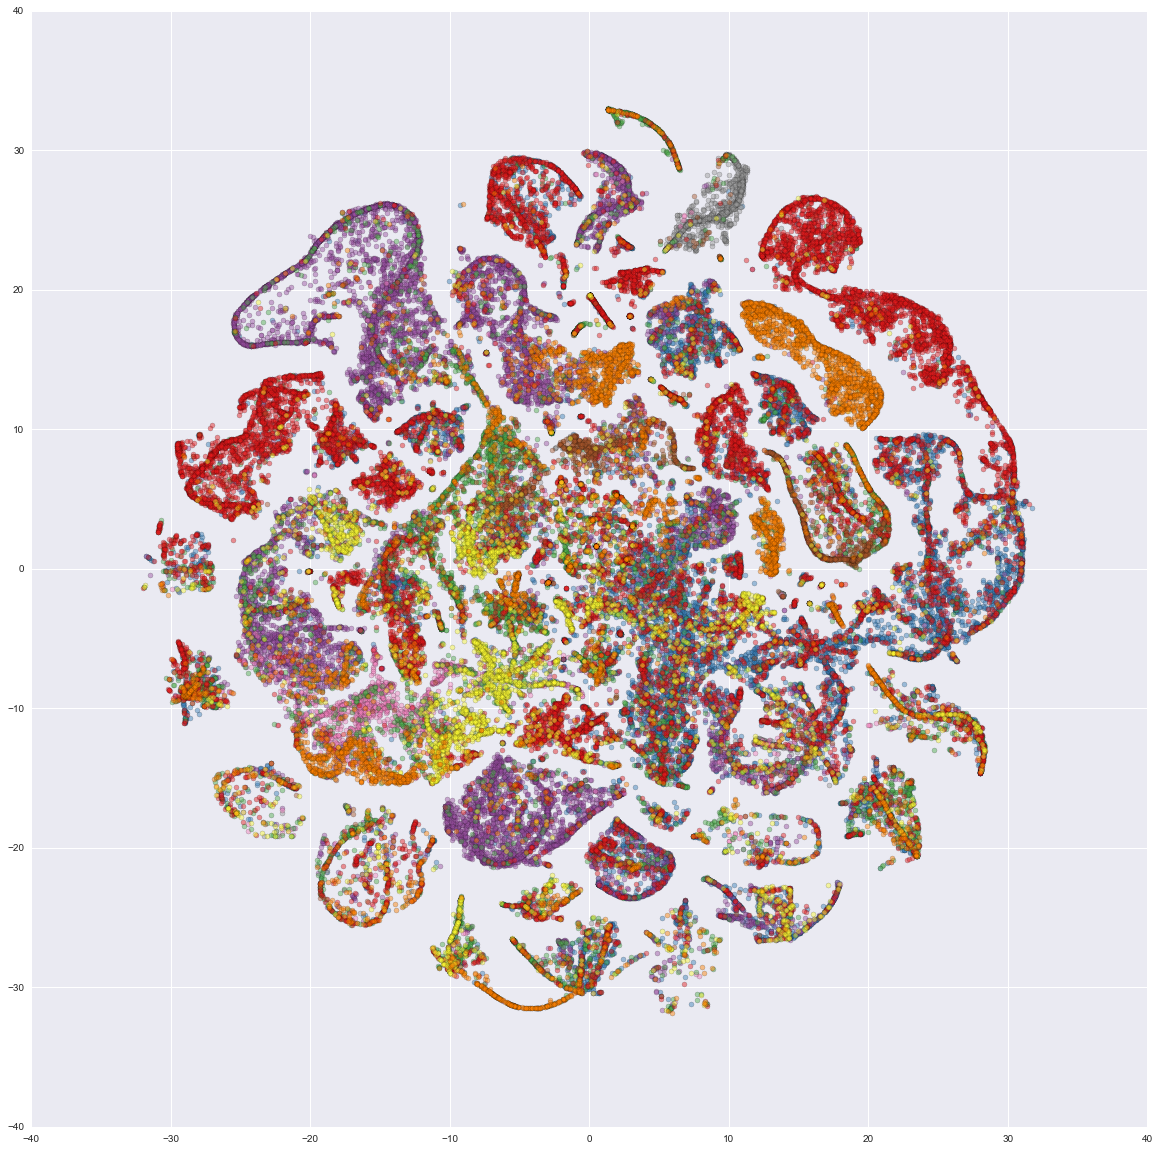

In [167]:
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import scipy.io as sio
import seaborn
from seaborn import color_palette

N=112312

features = np.load('/Users/jaredlorince/git/MusicForaging/GenreModeling/data/features/lda_artists/features_190.npy')[:N]

genre_data = pd.read_csv("/Users/jaredlorince/git/MusicForaging/GenreModeling/data/gracenote_genre_data.csv")
genre_data = genre_data[:len(features)]



#for fi in ()
#test1 = np.load('/Users/jaredlorince/Downloads/tsne_test_10000.npy')[:N]
#test1 = np.load('/Users/jaredlorince/Downloads/result_50k.npy')[:N]
#test1 = np.loadtxt('/Users/jaredlorince/git/lib/bhtsne/output',delimiter='\t')[:N]
#test1 = sio.loadmat('/Users/jaredlorince/Downloads/tSNE_matlab/result_20k.mat')['result'][:N]
test1 = np.loadtxt('/Users/jaredlorince/git/lib/bhtsne/output_normed',delimiter='\t')[:N]


def get_color(genre):
    if genre is np.nan or genre=='other':
        genre = 'other/unknown'
    color = color_dict.get(genre)
    return genre,color


color_dict = dict(zip(['rock', 'alternative & punk', 'pop', 'electronica', 'urban',
       'traditional', 'soundtrack', 'jazz', 'classical'],['#%02x%02x%02x' % (a, b, c) for a,b,c in np.round(255*np.array(color_palette("Set1",n_colors=9))).astype(int)]))
color_dict['other/unknown'] = '#000000'

colors = np.array([get_color(g)[1] for g in genre_data['genre1'].values[:len(features)]])

# fig,axes = plt.subplots(1,2,figsize=(20,10))
# for ax,data in zip(axes,[test1,test2]):
#     for g in sorted(color_dict.keys()):
#         if g == 'other/unkonwn':
#             indices = genre_data[(genre_data['genre1'].isin([np.nan,'other','unknown']))]['genre1'].index.values
#         else:
#             indices = genre_data[genre_data['genre1']==g]['genre1'].index.values
#         ax.scatter(data[indices,0],data[indices,1],c=color_dict[g],s=25,alpha=0.45)
#         legend_line_1 = ax.plot(np.NaN, np.NaN, marker = '.', ls='',ms=15, label=g, c=color_dict[g])
    
    
#     ax.grid()
#     ax.legend(loc='upper left',ncol=3)

fig,ax = plt.subplots(1,1,figsize=(20,20))
for g in sorted(color_dict.keys()):
    if g == 'other/unkonwn':
        indices = genre_data[(genre_data['genre1'].isin([np.nan,'other','unknown']))]['genre1'].index.values
    else:
        indices = genre_data[genre_data['genre1']==g]['genre1'].index.values
    ax.scatter(test1[indices,0],test1[indices,1],c=color_dict[g],s=25,alpha=0.45)
    legend_line_1 = ax.plot(np.NaN, np.NaN, marker = '.', ls='',ms=15, label=g, c=color_dict[g])
    
#ax.set_xticklabels([])
#ax.set_yticklabels([])

#ax.axvline(-8.21141179,c='k')
#ax.axhline(3.52799834,c='k')
    
ax.legend(loc='upper left',ncol=3)
ax.grid()
#fig.savefig('/Users/jaredlorince/Desktop/tsne.png',dpi=200,bbox_inches='tight')

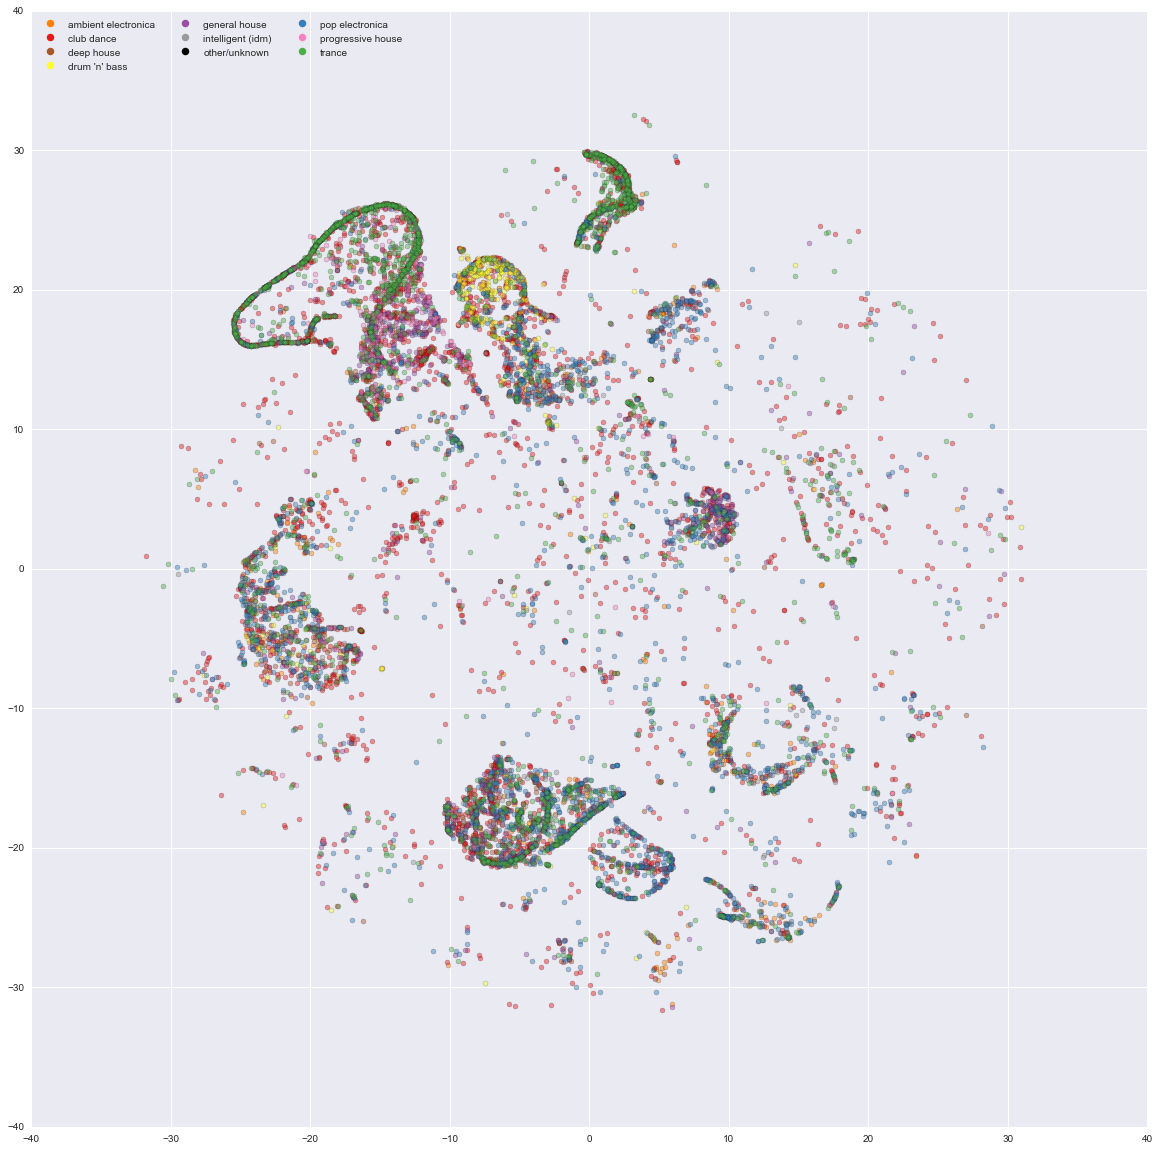

In [181]:
base_genre = 'electronica'
level = '3'
#urban = genre_data[genre_data['genre1']==base_genre]['genre'+level].unique()
urban = genre_data[genre_data['genre1']==base_genre]['genre'+level].value_counts()[:9].index
color_dict = dict(zip(urban,['#%02x%02x%02x' % (a, b, c) for a,b,c in np.round(255*np.array(color_palette("Set1",n_colors=len(urban)))).astype(int)]))
color_dict['other/unknown'] = '#000000'

colors = np.array([get_color(g)[1] for g in genre_data['genre2'].values[:len(features)]])


fig,ax = plt.subplots(1,1,figsize=(20,20))
for g in sorted(color_dict.keys()):
    if g == 'other/unkonwn':
        indices = genre_data[(genre_data['genre'+level].isin([np.nan,'other','unknown']))]['genre1'].index.values
    else:
        indices = genre_data[genre_data['genre'+level]==g]['genre'+level].index.values
    ax.scatter(test1[indices,0],test1[indices,1],c=color_dict[g],s=25,alpha=0.45)
    legend_line_1 = ax.plot(np.NaN, np.NaN, marker = '.', ls='',ms=15, label=g, c=color_dict[g])
    
ax.legend(loc='upper left',ncol=3)


In [17]:
from urllib import quote_plus
eno = pd.read_table('/Users/jaredlorince/git/MusicDataCollectors/EveryNoiseAtOnce/eno_data.tsv',header=None,names=['eno_genre','artist','wt'])
eno['artist_formatted'] = eno['artist'].apply(lambda s: quote_plus(str(s).lower()))
eno_grp = eno.groupby('artist_formatted').apply(lambda df: list(df.sort_values(by='wt',ascending=False)['eno_genre']))

In [18]:
#joined = genre_data.set_index('index').join(pd.DataFrame({'genres':eno_grp}))
def filterer(row,genre):
    genres = row['genres']
    if type(genres)==list:
        if genre in genres:
            return True
    return False
#eno['eno_genre'].value_counts()[20:40]
eno_grp.head()

artist_formatted
%21%21%21            [dance-punk, new rave, alternative dance, indi...
%21action+pact%21                          [anarcho-punk, gothic rock]
%21deladap                               [balkan brass, electro swing]
%21t.o.o.h.%21       [technical death metal, jazz metal, brutal dea...
%23%23%23%23%23                    [russian alternative, russian rock]
dtype: object

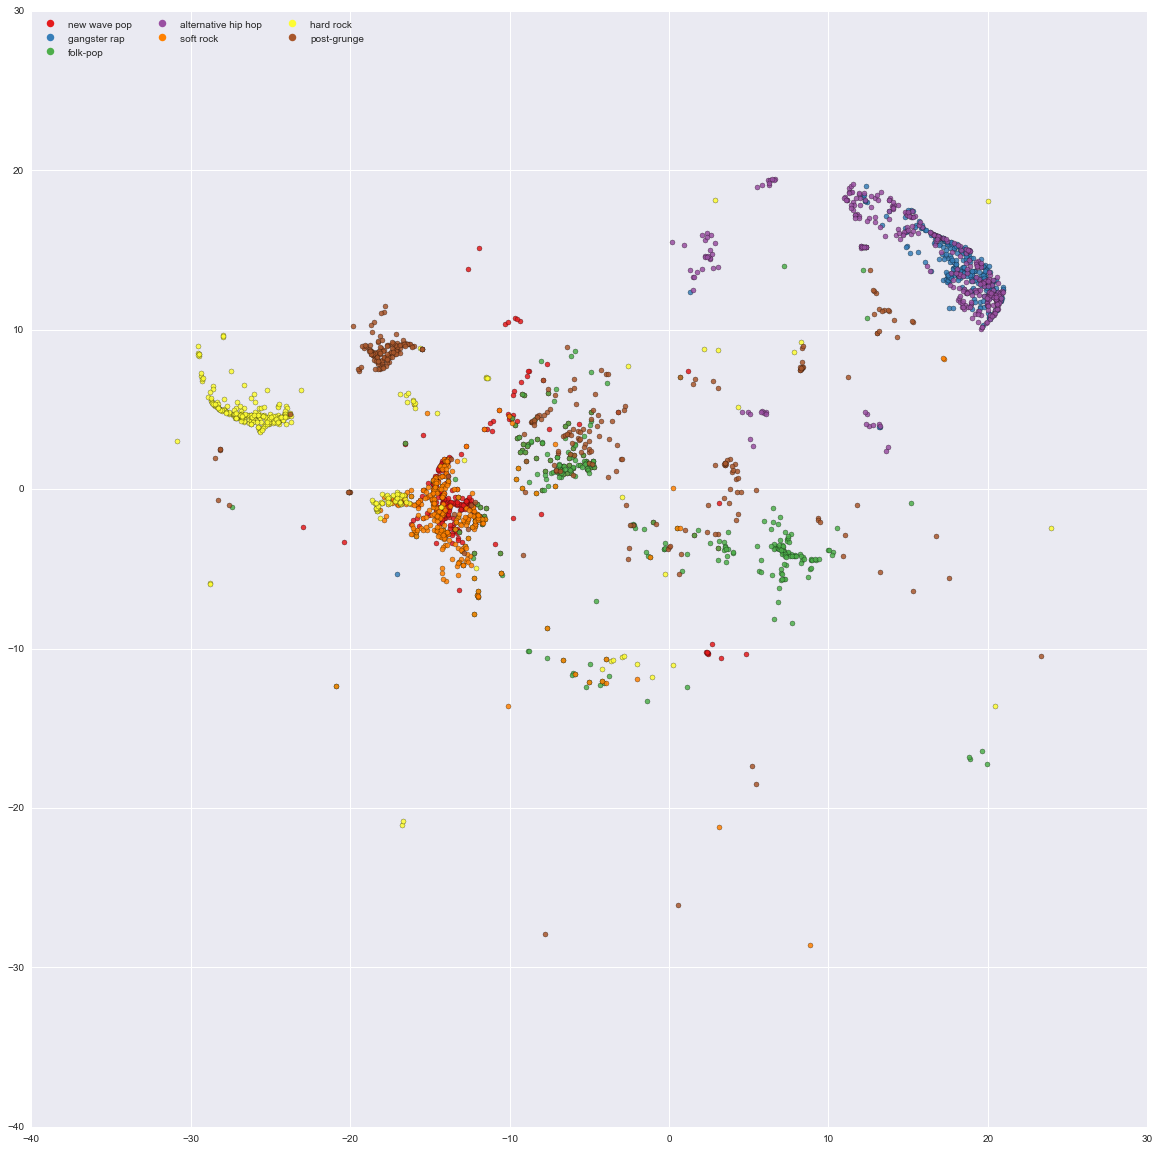

In [273]:
genres = ['new wave pop','gangster rap','folk-pop','alternative hip hop','soft rock','hard rock','post-grunge']
colors = ['#%02x%02x%02x' % (a, b, c) for a,b,c in np.round(255*np.array(color_palette("Set1",n_colors=len(genres)))).astype(int)]
test1 = np.loadtxt('/Users/jaredlorince/git/lib/bhtsne/output_normed',delimiter='\t')

fig,ax = plt.subplots(1,1,figsize=(20,20))
for g,c in zip(genres,colors):
    indices = np.where(joined.apply(filterer,args=(g,),axis=1)==True)
    ax.scatter(test1[indices,0],test1[indices,1],c=c,s=25,alpha=0.85)
    legend_line_1 = ax.plot(np.NaN, np.NaN, marker = '.', ls='',ms=15, label=g, c=c)
    
ax.legend(loc='upper left',ncol=3)


In [261]:
genres = ['rock','jazz']
colors = ['#%02x%02x%02x' % (a, b, c) for a,b,c in np.round(255*np.array(color_palette("Set1",n_colors=len(genres)))).astype(int)]
colors

['#e41a1c', '#377eb8']

In [220]:
features = np.load('/Users/jaredlorince/git/MusicForaging/GenreModeling/data/features/lda_artists/features_190.npy')
#genre_data.iloc[563],genre_data.iloc[1000]
cosine(features[26842],features[4499])
#test1[563],test1[1000]

0.99991788383160973

In [164]:
N=20000
features = np.load('/Users/jaredlorince/git/MusicForaging/GenreModeling/data/features/lda_artists/features_190.npy')[:N]

dists = pairwise_distances(features,metric='cosine')

# genre_data = pd.read_csv("/Users/jaredlorince/git/MusicForaging/GenreModeling/data/gracenote_genre_data.csv")
# genre_data = genre_data[:len(features)]

#test1 = np.loadtxt('/Users/jaredlorince/git/lib/bhtsne/output',delimiter='\t')[:N]


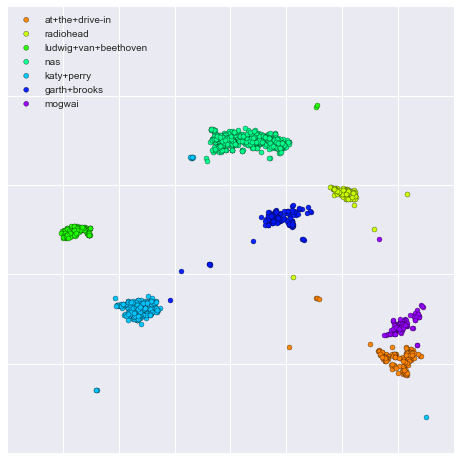

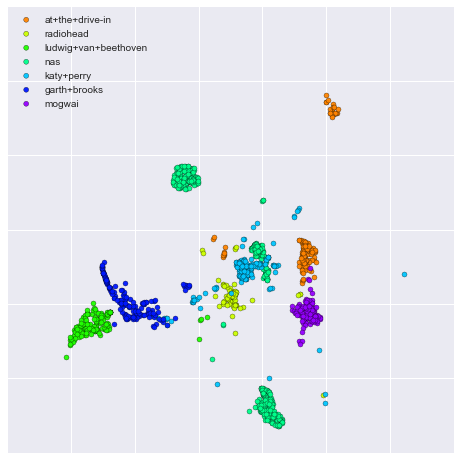

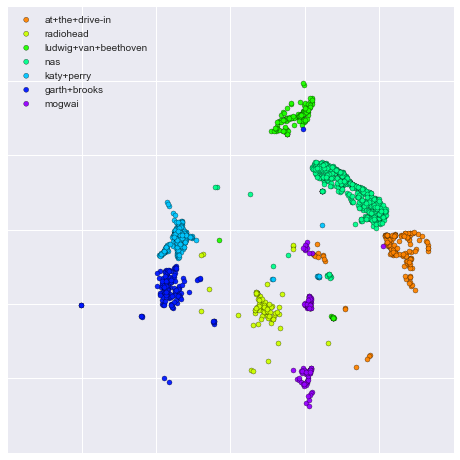

In [166]:
N=20000
test1 = sio.loadmat('/Users/jaredlorince/Downloads/tSNE_matlab/result_20k.mat')['result'][:N]
test2 = np.loadtxt('/Users/jaredlorince/git/lib/bhtsne/output',delimiter='\t')[:N]
test3 = np.loadtxt('/Users/jaredlorince/git/lib/bhtsne/output_normed',delimiter='\t')[:N]

for test in (test1,test2,test3):

    fig,ax = plt.subplots(1,1,figsize=(8,8))

    seed_artists = ('at+the+drive-in','radiohead','ludwig+van+beethoven','nas','katy+perry','garth+brooks','mogwai')#,'hans+zimmer','charlie+parker','the+clash','the+who','aesop+rock')
    #seed_artists=('ludwig+van+beethoven','nas','katy+perry',)
    a_colors = ['#%02x%02x%02x' % (a, b, c) for a,b,c in np.round(255*np.array(seaborn.color_palette('gist_rainbow',n_colors=len(seed_artists)))).astype(int)]
    for a,c in zip(seed_artists,a_colors):
        idx = names[a]
        neighbors = np.where(dists[idx]<=0.3)
        neighbors = neighbors[neighbors<N]
        ax.scatter(test[neighbors,0],test[neighbors,1],s=25,alpha=0.95,c=c,label=a)    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    # ax.set_xlim(-40,40);
    # ax.set_ylim(-40,40);
    ax.legend(loc='upper left')

In [8]:
features = np.load('/Users/jaredlorince/git/MusicForaging/GenreModeling/data/features/lda_artists/features_190.npy')

In [9]:
from sklearn.preprocessing import Normalizer
nrm = Normalizer('l2')
normed = nrm.fit_transform(features)

In [24]:
dists = pdist(features[:10000],metric='cosine')
n_dists = pdist(normed[:5000],metric='euclidean')

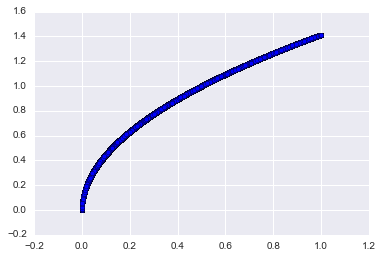

In [15]:
plt.scatter(dists,n_dists)

In [27]:
test1 = pdist(np.loadtxt('/Users/jaredlorince/git/lib/bhtsne/output_normed',delimiter='\t')[:10000],metric='euclidean')
# test2 = pdist(np.loadtxt('/Users/jaredlorince/git/lib/bhtsne/output',delimiter='\t')[:10000],metric='euclidean')
# test3 = pdist(np.loadtxt('/Users/jaredlorince/git/lib/bhtsne/output_normed_p100',delimiter='\t')[:10000],metric='euclidean')
#test4 = pdist(np.loadtxt('/Users/jaredlorince/git/lib/bhtsne/output_normed_p25',delimiter='\t')[:10000],metric='euclidean')
test5 = pdist(np.loadtxt('/Users/jaredlorince/git/lib/bhtsne/output_normed_t2',delimiter='\t')[:10000],metric='euclidean')
test6 = pdist(sio.loadmat('/Users/jaredlorince/Downloads/tSNE_matlab/result_normed_10k.mat')['result'],metric='euclidean')
test7 = pdist(np.loadtxt('/Users/jaredlorince/git/lib/bhtsne/output_normed_t1',delimiter='\t')[:10000],metric='euclidean')


In [28]:
from scipy.stats import spearmanr,pearsonr

#pearsonr(dists,test1),pearsonr(dists,test2),pearsonr(dists,test3),pearsonr(dists,test4),
pearsonr(dists,test1), pearsonr(dists,test5),pearsonr(dists,test6),pearsonr(dists,test7)

((0.32235936910712548, 0.0),
 (0.3361295472168479, 0.0),
 (0.35380586644036982, 0.0),
 (0.3320841726295119, 0.0))

In [212]:
spearmanr(dists,test6)

SpearmanrResult(correlation=0.35611266227314831, pvalue=0.0)